In [6]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import torch

import os
from dotenv import load_dotenv

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

load_dotenv()

True

# Загрузка данных

In [4]:
conn = psycopg2.connect(os.environ["POSTGRES_CONN"])

In [5]:
# Таблица с пользователями
user_data = pd.read_sql("SELECT * FROM user_data", conn)
user_data

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [5]:
user_data.nunique()

user_id      163205
gender            2
age              76
country          11
city           3915
exp_group         5
os                2
source            2
dtype: int64

In [4]:
# Таблица с постами
post_text_df = pd.read_sql("SELECT * FROM post_text_df", conn)
post_text_df

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


Эмбеддинг для текста

In [5]:
vector = torch.load('/Users/dmitry/Documents/code/Start_ML/module_2/final_project/df_vector')
vector

array([[-0.04026394, -0.27968097, -0.02639238, ...,  0.257868  ,
         0.18739226,  0.31604615],
       [-0.10243215, -0.29358044,  0.02447986, ...,  0.19320787,
         0.10278795,  0.06712697],
       [-0.17103201, -0.196974  ,  0.11955357, ...,  0.11110002,
         0.16093004,  0.06588535],
       ...,
       [-0.23448637, -0.46378005,  0.46819142, ...,  0.14383662,
         0.31123495, -0.15421167],
       [-0.03112065, -0.23907664,  0.12080344, ...,  0.23640299,
         0.34705564,  0.07306456],
       [-0.55892557, -0.23251152,  0.05662002, ...,  0.05255096,
         0.51426667,  0.06540442]], dtype=float32)

In [10]:
post_text_df.nunique()

post_id    7023
text       6924
topic         7
dtype: int64

In [11]:
post_text_df.isna().any()

post_id    False
text       False
topic      False
dtype: bool

In [35]:
# Таблица с действиями
feed_data = pd.read_sql(
    """
    SELECT user_id, timestamp, action, post_id, target
    FROM (
        SELECT *,
               ROW_NUMBER() OVER (PARTITION BY user_id) as row_num
        FROM feed_data
    ) AS ranked
    WHERE row_num <= 5;
    """, conn)
feed_data.index.name = 'fd_id'
feed_data

,user_id,timestamp,action,post_id,target
fd_id,,,,,
0,200,2021-12-13 08:16:21,like,1198,0
1,200,2021-12-13 08:16:23,view,7143,1
2,200,2021-12-13 08:18:54,like,7143,0
3,200,2021-12-13 08:18:56,view,681,0
4,200,2021-12-13 08:19:39,view,3447,0
...,...,...,...,...,...
816020,168552,2021-12-23 10:56:21,view,735,0
816021,168552,2021-12-23 10:55:40,view,4430,0
816022,168552,2021-12-23 10:53:33,view,3800,0


In [13]:
feed_data.nunique()

user_id      163205
timestamp    597233
action            2
post_id        6831
target            2
dtype: int64

In [14]:
print(f'Начальная дата: {min(feed_data["timestamp"])}')
print(f'Конечная дата: {max(feed_data["timestamp"])}')

Начальная дата: 2021-10-01 06:01:40
Конечная дата: 2021-12-29 23:51:06


# Генерация признаков

Создать признаки для постов и пользователей отдельно

In [36]:
feed_data.drop(feed_data[feed_data['action'] == 'like'].index, axis=0, inplace=True)
feed_data.drop('action', axis=1, inplace=True)
feed_data

,user_id,timestamp,post_id,target
fd_id,,,,
1,200,2021-12-13 08:16:23,7143,1
3,200,2021-12-13 08:18:56,681,0
4,200,2021-12-13 08:19:39,3447,0
5,201,2021-11-30 15:25:03,154,1
7,201,2021-11-30 15:25:22,3228,0
...,...,...,...,...
816020,168552,2021-12-23 10:56:21,735,0
816021,168552,2021-12-23 10:55:40,4430,0
816022,168552,2021-12-23 10:53:33,3800,0


#### Признаки для поста

In [8]:
post_text_df['total_len'] = post_text_df['text'].apply(len)
post_text_df.head()

,post_id,text,topic,total_len
0,1,UK economy facing major risks\n\nThe UK manufa...,business,1967
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,2701
2,3,Asian quake hits European shares\n\nShares in ...,business,3408
3,4,India power shares jump on debut\n\nShares in ...,business,1026
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,889


In [9]:
# Создание экземпляра модели k ближайших соседей
knn = NearestNeighbors(n_neighbors=5, metric='cosine')

# Обучение модели на эмбеддингах
knn.fit(vector)

# Получение расстояний и индексов k ближайших соседей для каждого эмбеддинга
distances, indices = knn.kneighbors(vector)

# Преобразование расстояний и индексов в числовые признаки
# Например, можно использовать среднее расстояние до k ближайших соседей
vec_to_num = distances.mean(axis=1)
vec_to_num

array([0.08227593, 0.11509974, 0.06522653, ..., 0.11990206, 0.10609498,
       0.12071379], dtype=float32)

In [10]:
# Понижение размерности эмбеддинга для текста
pca = PCA(n_components=40)
vector_reduced = pca.fit_transform(vector)
vector_reduced

array([[-0.6042926 , -1.7302293 , -0.2656291 , ..., -0.09555924,
         0.08054186,  0.08684012],
       [-0.37933505, -1.6182517 , -0.18222351, ...,  0.35344905,
        -0.10349544,  0.1552207 ],
       [-0.57943225, -1.3125701 , -0.5366196 , ...,  0.02226187,
        -0.2557233 ,  0.26743233],
       ...,
       [-0.3394548 ,  1.7820189 , -0.08271557, ...,  0.0446398 ,
        -0.10677332,  0.3640736 ],
       [-0.85119724,  1.3939445 ,  0.2535691 , ..., -0.14826623,
        -0.3795626 , -0.34804788],
       [-0.59959245,  1.1673808 ,  0.4794963 , ..., -0.35850045,
         0.28456897, -0.04457804]], dtype=float32)

In [11]:
post_text_df['vector_knn'] = vec_to_num
post_text_df

,post_id,text,topic,total_len,vector_knn
0,1,UK economy facing major risks\n\nThe UK manufa...,business,1967,0.082276
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,2701,0.115100
2,3,Asian quake hits European shares\n\nShares in ...,business,3408,0.065227
3,4,India power shares jump on debut\n\nShares in ...,business,1026,0.166756
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,889,0.128059
...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,803,0.118923
7019,7316,I give this movie 2 stars purely because of it...,movie,800,0.102609
7020,7317,I cant believe this film was allowed to be mad...,movie,636,0.119902
7021,7318,The version I saw of this film was the Blockbu...,movie,728,0.106095


In [12]:
post_text_df = pd.concat([post_text_df, pd.DataFrame(vector_reduced)], axis=1)
post_text_df.head()


,post_id,text,topic,total_len,vector_knn,0,1,2,3,4,...,30,31,32,33,34,35,36,37,38,39
0,1,UK economy facing major risks\n\nThe UK manufa...,business,1967,0.082276,-0.604293,-1.730229,-0.265629,-0.287930,0.902613,...,0.013911,-0.252469,0.059033,0.209930,0.225182,-0.543558,-0.145053,-0.095559,0.080542,0.086840
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,2701,0.115100,-0.379335,-1.618252,-0.182224,0.393784,0.074997,...,0.181107,-0.186352,0.142517,0.010612,-0.416863,-0.092074,-0.198007,0.353449,-0.103495,0.155221
2,3,Asian quake hits European shares\n\nShares in ...,business,3408,0.065227,-0.579432,-1.312570,-0.536620,-0.314556,0.692388,...,0.123431,-0.224471,-0.100773,-0.157203,-0.100837,0.494602,-0.045970,0.022262,-0.255723,0.267432
3,4,India power shares jump on debut\n\nShares in ...,business,1026,0.166756,-0.001005,-1.071291,-0.340120,-0.310131,0.935006,...,-0.119648,0.206233,-0.000893,-0.041723,-0.247718,0.399846,0.202233,0.106277,0.394018,-0.230528
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,889,0.128059,0.009501,-0.748033,0.456167,-0.182601,0.857853,...,0.259831,0.160582,0.282803,0.008371,0.308162,-0.481156,-0.394653,-0.034847,0.389736,-0.022782


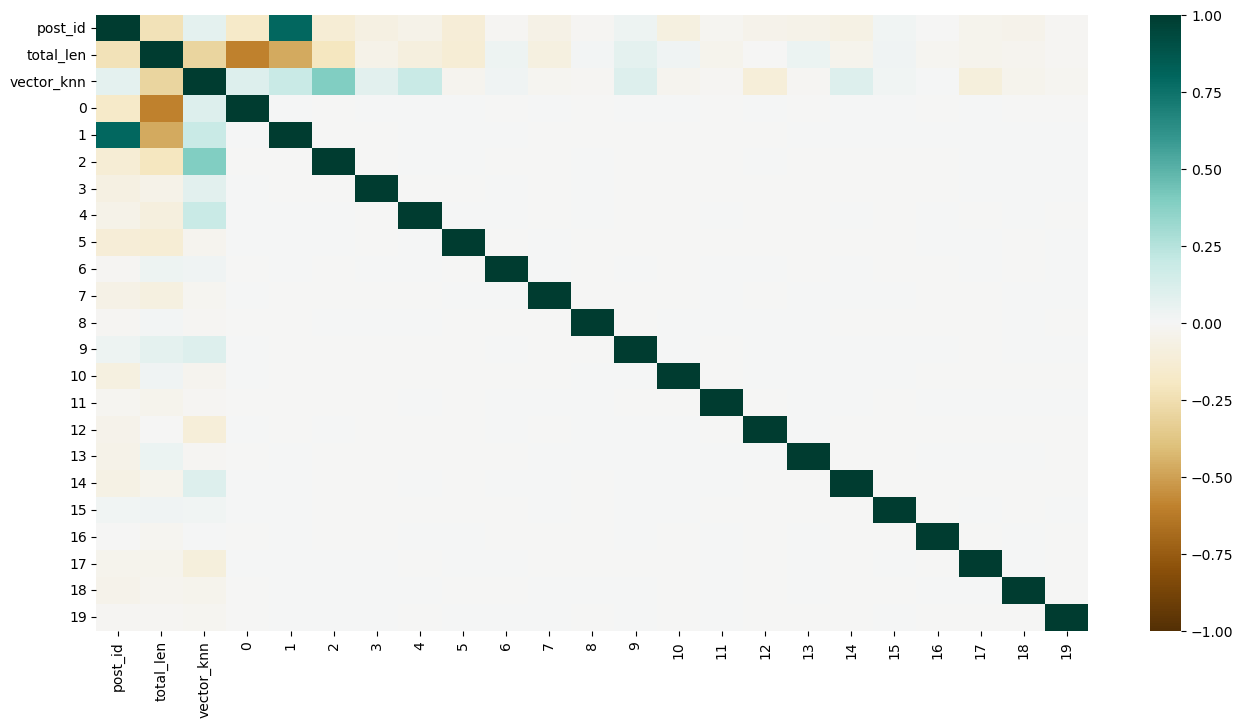

In [71]:
numeric_columns = post_text_df.loc[:, post_text_df.dtypes!=object].columns

fig = plt.figure()

fig.set_size_inches(16, 8)

sns.heatmap(post_text_df[numeric_columns].corr(), 
            xticklabels=numeric_columns,
            yticklabels=numeric_columns,
            cmap='BrBG',
            vmin=-1,
            vmax=1)

plt.show()

#### Кодирование категориальных колонок

In [64]:
post_text_df['vector'] = vector_reduced.tolist()
post_text_df

,post_id,text,topic,total_len,vector
0,1,UK economy facing major risks\n\nThe UK manufa...,business,1967,"[-0.6042978763580322, -1.730239748954773, -0.2..."
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,2701,"[-0.37933528423309326, -1.6182550191879272, -0..."
2,3,Asian quake hits European shares\n\nShares in ...,business,3408,"[-0.579432487487793, -1.312570571899414, -0.53..."
3,4,India power shares jump on debut\n\nShares in ...,business,1026,"[-0.0010050029959529638, -1.0712916851043701, ..."
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,889,"[0.009501454420387745, -0.7480331063270569, 0...."
...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,803,"[-0.9605499505996704, 1.2869004011154175, 0.59..."
7019,7316,I give this movie 2 stars purely because of it...,movie,800,"[-0.9987666010856628, 1.1713253259658813, -0.4..."
7020,7317,I cant believe this film was allowed to be mad...,movie,636,"[-0.3394550383090973, 1.7820202112197876, -0.0..."
7021,7318,The version I saw of this film was the Blockbu...,movie,728,"[-0.8511978387832642, 1.3939452171325684, 0.25..."


In [32]:
one_hot = pd.get_dummies(post_text_df['topic'], prefix='topic', drop_first=True, dtype=int)
post_text_df = pd.concat((post_text_df.drop('topic', axis=1), one_hot), axis=1)
post_text_df.drop('text', axis=1, inplace=True)
post_text_df.head()

,post_id,total_len,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
0,1,1967,0,0,0,0,0,0
1,2,2701,0,0,0,0,0,0
2,3,3408,0,0,0,0,0,0
3,4,1026,0,0,0,0,0,0
4,5,889,0,0,0,0,0,0


#### Сохранение

In [13]:
post_text_df.drop('text', axis=1, inplace=True)

In [14]:
post_text_df.to_csv('/Users/dmitry/Documents/code/Start_ML/module_2/final_project/data/post_feachures_2.csv', index=False)

##### Признаки для пользователя

In [37]:
data = pd.merge(feed_data, user_data, on='user_id', how='left')
data.head()

,user_id,timestamp,post_id,target,gender,age,country,city,exp_group,os,source
0,200,2021-12-13 08:16:23,7143,1,1,34,Russia,Degtyarsk,3,Android,ads
1,200,2021-12-13 08:18:56,681,0,1,34,Russia,Degtyarsk,3,Android,ads
2,200,2021-12-13 08:19:39,3447,0,1,34,Russia,Degtyarsk,3,Android,ads
3,201,2021-11-30 15:25:03,154,1,0,37,Russia,Abakan,0,Android,ads
4,201,2021-11-30 15:25:22,3228,0,0,37,Russia,Abakan,0,Android,ads


In [38]:
data.drop_duplicates(subset='user_id', inplace=True, ignore_index=True)
user_data = data[['user_id', 'gender', 'age', 'country',	'city', 'exp_group', 'os', 'source']].copy()
user_data

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


##### Кодирование категориальных колонок

In [35]:
cat_cols = ['country',	'city',	'os', 'source']


for col in cat_cols:
    if data[col].nunique() < 3:
        one_hot = pd.get_dummies(data[col], prefix=col, drop_first=True, dtype=int)
        data = pd.concat((data.drop(col, axis=1), one_hot), axis=1)
        
    else:
        mean_target = data.groupby(col)['target'].mean()
        data[col] = data[col].map(mean_target)


data.head()

,user_id,timestamp,post_id,target,gender,age,country,city,exp_group,os_iOS,source_organic
0,200,2021-12-29 15:24:59,1773,0,1,34,0.109227,0.075269,3,0,0
1,200,2021-10-02 14:02:19,5057,0,1,34,0.109227,0.075269,3,0,0
2,200,2021-10-02 14:02:31,4872,0,1,34,0.109227,0.075269,3,0,0
3,200,2021-10-02 14:03:48,5431,0,1,34,0.109227,0.075269,3,0,0
4,200,2021-10-02 14:05:32,6829,0,1,34,0.109227,0.075269,3,0,0


##### Сохранение

In [18]:
user_data.to_csv('/Users/dmitry/Documents/code/Start_ML/module_2/final_project/data/user_feachures_2.csv', index=False)

In [2]:
user_data = pd.read_csv('/Users/dmitry/Documents/code/Start_ML/module_2/final_project/data/user_feachures_1.csv')

# Создание обучающей выборки

## Объединение таблиц

In [39]:
data = pd.merge(feed_data,
                user_data,
                on='user_id',
                how='left'
                )

data

,user_id,timestamp,post_id,target,gender,age,country,city,exp_group,os,source
0,200,2021-12-13 08:16:23,7143,1,1,34,Russia,Degtyarsk,3,Android,ads
1,200,2021-12-13 08:18:56,681,0,1,34,Russia,Degtyarsk,3,Android,ads
2,200,2021-12-13 08:19:39,3447,0,1,34,Russia,Degtyarsk,3,Android,ads
3,201,2021-11-30 15:25:03,154,1,0,37,Russia,Abakan,0,Android,ads
4,201,2021-11-30 15:25:22,3228,0,0,37,Russia,Abakan,0,Android,ads
...,...,...,...,...,...,...,...,...,...,...,...
733316,168552,2021-12-23 10:56:21,735,0,1,16,Russia,Ivanteyevka,4,Android,organic
733317,168552,2021-12-23 10:55:40,4430,0,1,16,Russia,Ivanteyevka,4,Android,organic
733318,168552,2021-12-23 10:53:33,3800,0,1,16,Russia,Ivanteyevka,4,Android,organic
733319,168552,2021-12-23 10:52:41,2820,0,1,16,Russia,Ivanteyevka,4,Android,organic


In [40]:
data = pd.merge(data,
                post_text_df,
                on='post_id',
                how='left'
                )
data

,user_id,timestamp,post_id,target,gender,age,country,city,exp_group,os,...,30,31,32,33,34,35,36,37,38,39
0,200,2021-12-13 08:16:23,7143,1,1,34,Russia,Degtyarsk,3,Android,...,-0.170018,0.087750,0.191774,0.456299,-0.017689,0.152430,0.254168,-0.833396,0.101887,-0.209702
1,200,2021-12-13 08:18:56,681,0,1,34,Russia,Degtyarsk,3,Android,...,-0.091563,-0.078503,-0.208893,-0.010154,-0.183850,0.324670,0.073867,0.385027,0.399379,-0.001401
2,200,2021-12-13 08:19:39,3447,0,1,34,Russia,Degtyarsk,3,Android,...,0.177565,0.102537,-0.263699,-0.340035,-0.315198,0.245788,-0.186817,-0.296658,-0.297707,-0.098864
3,201,2021-11-30 15:25:03,154,1,0,37,Russia,Abakan,0,Android,...,-0.250387,-0.260513,0.067873,-0.183537,0.172798,-0.080280,0.191953,0.444190,0.025500,0.039938
4,201,2021-11-30 15:25:22,3228,0,0,37,Russia,Abakan,0,Android,...,0.552957,-0.170581,-0.356583,0.086687,0.182480,0.465753,0.054125,-0.390776,-0.446113,0.138624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733316,168552,2021-12-23 10:56:21,735,0,1,16,Russia,Ivanteyevka,4,Android,...,0.067269,0.164740,-0.249304,-0.067460,0.504516,-0.347005,0.034146,0.115369,0.372907,0.194144
733317,168552,2021-12-23 10:55:40,4430,0,1,16,Russia,Ivanteyevka,4,Android,...,-0.075231,0.659221,0.010304,0.057197,-0.335372,-0.388869,-0.079579,-0.069047,-0.110329,-0.452734
733318,168552,2021-12-23 10:53:33,3800,0,1,16,Russia,Ivanteyevka,4,Android,...,0.033160,0.201975,0.599422,-0.036241,-0.480467,0.336226,0.583920,0.317172,0.275646,-0.484753
733319,168552,2021-12-23 10:52:41,2820,0,1,16,Russia,Ivanteyevka,4,Android,...,0.377946,-0.245142,0.323612,-1.036494,0.752671,-0.350036,-0.078449,-0.327689,0.114011,-0.352519


In [41]:
data['weekday'] = data.timestamp.dt.weekday
data['hour'] = data.timestamp.dt.hour
data.head()

,user_id,timestamp,post_id,target,gender,age,country,city,exp_group,os,...,32,33,34,35,36,37,38,39,weekday,hour
0,200,2021-12-13 08:16:23,7143,1,1,34,Russia,Degtyarsk,3,Android,...,0.191774,0.456299,-0.017689,0.152430,0.254168,-0.833396,0.101887,-0.209702,0,8
1,200,2021-12-13 08:18:56,681,0,1,34,Russia,Degtyarsk,3,Android,...,-0.208893,-0.010154,-0.183850,0.324670,0.073867,0.385027,0.399379,-0.001401,0,8
2,200,2021-12-13 08:19:39,3447,0,1,34,Russia,Degtyarsk,3,Android,...,-0.263699,-0.340035,-0.315198,0.245788,-0.186817,-0.296658,-0.297707,-0.098864,0,8
3,201,2021-11-30 15:25:03,154,1,0,37,Russia,Abakan,0,Android,...,0.067873,-0.183537,0.172798,-0.080280,0.191953,0.444190,0.025500,0.039938,1,15
4,201,2021-11-30 15:25:22,3228,0,0,37,Russia,Abakan,0,Android,...,-0.356583,0.086687,0.182480,0.465753,0.054125,-0.390776,-0.446113,0.138624,1,15


## Разделение на трейн и тест

In [22]:
from sklearn.model_selection import train_test_split 

In [42]:
X = data.drop(['target', 'user_id', 'post_id', 'timestamp'], axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [43]:
X_train

,gender,age,country,city,exp_group,os,source,topic,total_len,vector_knn,...,32,33,34,35,36,37,38,39,weekday,hour
567389,1,35,Russia,Volgograd,0,Android,organic,covid,112,0.151731,...,-0.160848,0.102494,-0.654615,0.381046,-0.074305,0.297248,0.078752,-0.239512,2,22
256689,0,15,Russia,Tver,3,iOS,ads,covid,136,0.134600,...,-0.213478,-0.262334,-0.344277,0.022356,-0.124328,0.117831,0.130508,-0.238669,0,6
554936,0,33,Russia,Krasnoyarsk,2,iOS,organic,covid,139,0.106137,...,-0.164404,0.016233,-0.053439,0.101196,0.038914,-0.055982,-0.160253,-0.043122,3,8
510020,0,24,Russia,Krasnoyarsk,0,Android,organic,sport,1502,0.100200,...,-0.159145,0.334118,0.051358,-0.283033,0.248850,-0.244669,0.136627,-0.123922,0,10
318857,0,52,Russia,Saint Petersburg,3,iOS,ads,covid,144,0.116328,...,-0.442781,0.177806,0.305040,0.504963,-0.249149,-0.141646,-0.535890,0.344655,2,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324570,1,22,Russia,Moscow,0,iOS,ads,covid,137,0.113894,...,0.469492,-0.423411,0.338028,0.030998,0.122405,-0.218073,0.731551,0.522433,3,16
231557,1,41,Russia,Nalchik,3,Android,ads,movie,382,0.130268,...,0.129792,-0.159767,-0.047554,0.602354,-0.141335,-0.270492,-0.134530,0.180729,2,16
149489,1,20,Russia,Glyadyanskoye,2,Android,ads,movie,1073,0.140535,...,-0.234523,-0.023770,-0.230731,-0.068340,0.108989,-0.079886,-0.308763,0.115474,5,10
550228,1,23,Russia,Rostov,1,iOS,organic,covid,140,0.153455,...,0.441806,-0.542391,-0.079556,-0.237511,0.139319,0.078983,-0.422333,-0.098074,5,10


# Обучение модели

In [25]:
from catboost import CatBoostClassifier
from sklearn.model_selection import ShuffleSplit

In [26]:
cat_feachures = list(X.select_dtypes(include=object).columns)

cat_feachures

['country', 'city', 'os', 'source', 'topic']

In [44]:
model = CatBoostClassifier(cat_features=cat_feachures, custom_loss='AUC')
 
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=50, early_stopping_rounds=80, plot=True)

model.save_model('/Users/dmitry/Documents/code/Start_ML/module_2/final_project/model/catboost_5_5')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.153003
0:	learn: 0.5849125	test: 0.5850577	best: 0.5850577 (0)	total: 213ms	remaining: 3m 32s
50:	learn: 0.3428567	test: 0.3429968	best: 0.3429968 (50)	total: 9.64s	remaining: 2m 59s
100:	learn: 0.3400216	test: 0.3413070	best: 0.3413070 (100)	total: 20.5s	remaining: 3m 2s
150:	learn: 0.3379263	test: 0.3402392	best: 0.3402392 (150)	total: 31.5s	remaining: 2m 57s
200:	learn: 0.3361576	test: 0.3397443	best: 0.3397330 (196)	total: 42.6s	remaining: 2m 49s
250:	learn: 0.3347609	test: 0.3394023	best: 0.3394005 (249)	total: 53.6s	remaining: 2m 39s
300:	learn: 0.3336282	test: 0.3392545	best: 0.3392512 (295)	total: 1m 4s	remaining: 2m 29s
350:	learn: 0.3324826	test: 0.3390141	best: 0.3390116 (348)	total: 1m 15s	remaining: 2m 19s
400:	learn: 0.3314317	test: 0.3389338	best: 0.3389210 (389)	total: 1m 26s	remaining: 2m 9s
450:	learn: 0.3304978	test: 0.3388309	best: 0.3388296 (449)	total: 1m 37s	remaining: 1m 58s
500:	learn: 0.3295663	test: 0.3387043	best: 0.3386926 (498)	total

In [55]:
model.get_cat_feature_indices()

[2, 3, 5, 6, 7]

In [104]:
model.feature_importances_

array([ 1.20780122, 15.75187701,  2.4310994 , 11.32831928,  7.66189316,
        0.23619918,  0.18045428,  3.78137922,  1.3397868 ,  1.53352471,
        2.68168189,  3.83050504,  1.92552998,  4.10636549,  1.50209572,
        1.08999126,  1.18951474,  2.01142575,  1.21313895,  2.31151813,
        1.67396307,  1.40991509,  1.29143944,  1.50312309,  1.71406731,
        1.30366712,  1.41265146,  1.46393333,  1.69137073,  1.25604839,
        1.38177539,  1.44710896,  1.01599417,  1.17090332,  1.02638106,
        1.36063145,  1.36492387,  1.32518166,  1.63916478,  1.46742812,
        0.94922963,  3.81699737])

In [105]:
np.argmin(model.feature_importances_)

6

In [32]:
new_model = CatBoostClassifier().load_model('/Users/dmitry/Documents/code/Start_ML/module_2/final_project/model/catboost_5')
new_model

In [34]:
new_model.get_cat_feature_indices()
new_model.get_embedding_feature_indices()

[8]

In [32]:
probabilities = model.predict_proba(X_test)[:, 1]
probabilities

array([0.16506028, 0.09958086, 0.20289726, ..., 0.07673958, 0.18599314,
       0.12333794])

In [106]:
model = CatBoostClassifier(random_state=8, cat_features=cat_feachures, verbose=50, early_stopping_rounds=50, custom_loss='AUC')
param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.1, 0.15, 0.2]
}

splitter = ShuffleSplit(n_splits=3)

grid_search = model.grid_search(param_grid=param_grid,
                                X=X_train, y=y_train, cv=splitter, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6197067	test: 0.6192660	best: 0.6192660 (0)	total: 235ms	remaining: 3m 54s
50:	learn: 0.3443244	test: 0.3392335	best: 0.3392335 (50)	total: 7.54s	remaining: 2m 20s
100:	learn: 0.3411493	test: 0.3368896	best: 0.3368896 (100)	total: 15.9s	remaining: 2m 21s
150:	learn: 0.3393908	test: 0.3360720	best: 0.3360720 (150)	total: 24.9s	remaining: 2m 19s
200:	learn: 0.3377912	test: 0.3353557	best: 0.3353517 (199)	total: 33.3s	remaining: 2m 12s
250:	learn: 0.3365797	test: 0.3350880	best: 0.3350880 (250)	total: 41.8s	remaining: 2m 4s
300:	learn: 0.3353763	test: 0.3348716	best: 0.3348634 (296)	total: 50.5s	remaining: 1m 57s
350:	learn: 0.3343930	test: 0.3347194	best: 0.3347194 (350)	total: 59s	remaining: 1m 49s
400:	learn: 0.3335007	test: 0.3346250	best: 0.3346151 (391)	total: 1m 7s	remaining: 1m 40s
450:	learn: 0.3326274	test: 0.3345350	best: 0.3345347 (447)	total: 1m 15s	remaining: 1m 32s
500:	learn: 0.3318063	test: 0.3344597	best: 0.3344576 (498)	total: 1m 24s	remaining: 1m 23s
550:	l

In [74]:
best_params = grid_search['params']
best_params

{'depth': 8, 'l2_leaf_reg': 2}

In [75]:
best_model = CatBoostClassifier(**best_params, random_state=8, early_stopping_rounds=50,
                                custom_loss=['AUC', 'Accuracy'],  cat_features=cat_feachures)

best_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)

model.save_model('/Users/dmitry/Documents/code/Start_ML/module_2/final_project/model/catboost_4_5')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))